Accuracy: 0.848
Precision: 0.8098591549295775
Recall: 0.9126984126984127
F1-score: 0.8582089552238806

Confusion matrix:
 [[ 97  27]
 [ 11 115]]

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84       124
           1       0.81      0.91      0.86       126

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250


Top positive coefficients (increase probability of treatment):
                     feature      coef
59  work_interfere_Sometimes  1.669741
57      work_interfere_Often  1.337666
58     work_interfere_Rarely  1.040285
46        family_history_Yes  0.426385
50          care_options_Yes  0.270535
52             anonymity_Yes  0.244525
53  leave_Somewhat difficult  0.184671
61       no_employees_26-100  0.164323
0                        Age  0.143492
55      leave_Very difficult  0.131249

Top negat

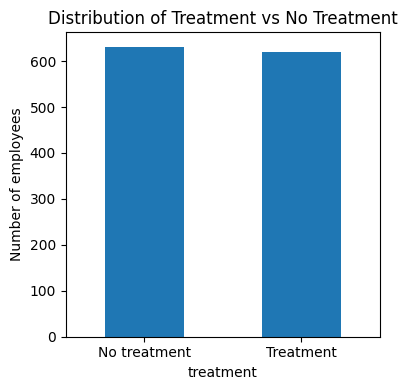

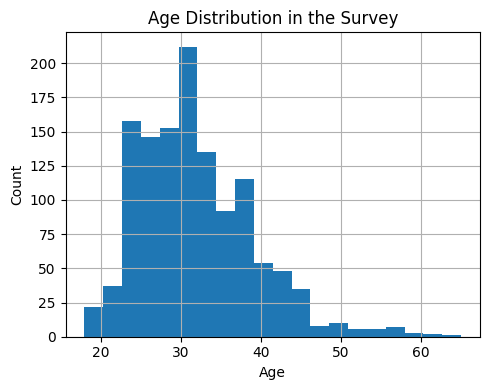

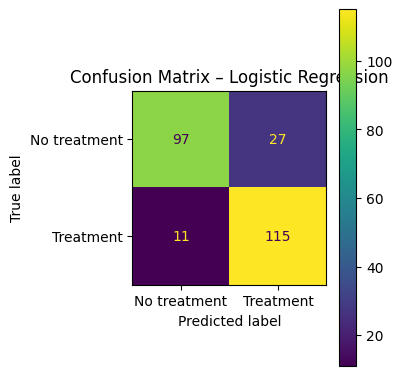

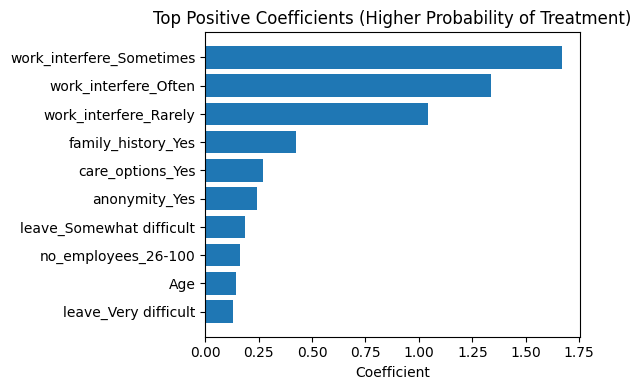

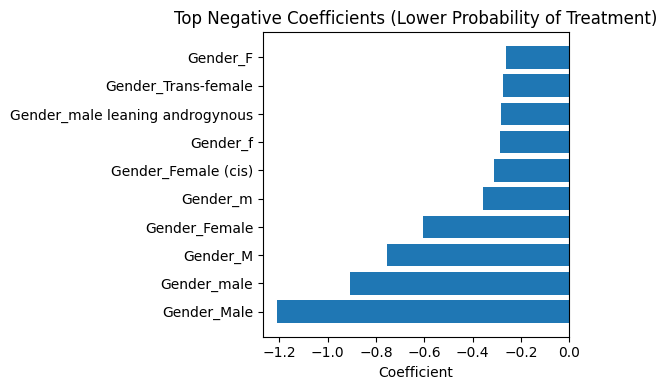

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1. Load data
df = pd.read_csv("sample_data/survey.csv")  # make sure the file name is correct

# 2. Basic cleaning

# Keep a sensible age range
df = df[(df["Age"] >= 18) & (df["Age"] <= 65)]

# Target: treatment (yes / no -> 1 / 0)
df["treatment"] = df["treatment"].map({"Yes": 1, "No": 0})

# Drop rows with missing target
df = df.dropna(subset=["treatment"])

# Example of columns to keep as features
# Adjust this list according to the actual column names in your CSV
feature_cols = [
    "Age",
    "Gender",
    "family_history",
    "benefits",
    "care_options",
    "anonymity",
    "leave",
    "work_interfere",
    "no_employees",
    "remote_work",
    "tech_company",
]

# Keep only columns that actually exist
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols]
y = df["treatment"]

# 3. Handle categorical variables with one‑hot encoding
X = pd.get_dummies(X, drop_first=True)

# 4. Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 5. (Optional) Scale numeric features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Logistic Regression model
log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    max_iter=1000
)
log_reg.fit(X_train_scaled, y_train)

# 7. Evaluation
y_pred = log_reg.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred))

# 8. Coefficients (feature importance)
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": log_reg.coef_[0]
}).sort_values("coef", ascending=False)

print("\nTop positive coefficients (increase probability of treatment):")
print(coef_df.head(10))

print("\nTop negative coefficients (decrease probability of treatment):")
print(coef_df.tail(10))

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# ===========================
# Figure for Slide 1: Treatment distribution
# ===========================

fig, ax = plt.subplots(figsize=(4, 4))
df["treatment"].value_counts().plot(kind="bar", ax=ax)

ax.set_xticklabels(["No treatment", "Treatment"], rotation=0)
ax.set_ylabel("Number of employees")
ax.set_title("Distribution of Treatment vs No Treatment")

plt.tight_layout()
fig.savefig("slide1_treatment_counts.png", dpi=300)
plt.show()


# ===========================
# Figure for Slide 2: Age distribution
# ===========================

fig, ax = plt.subplots(figsize=(5, 4))
df["Age"].hist(bins=20, ax=ax)

ax.set_xlabel("Age")
ax.set_ylabel("Count")
ax.set_title("Age Distribution in the Survey")

plt.tight_layout()
fig.savefig("slide2_age_hist.png", dpi=300)
plt.show()


# ===========================
# Figure for Slide 3: Confusion matrix
# ===========================

fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax,
    display_labels=["No treatment", "Treatment"]
)
ax.set_title("Confusion Matrix – Logistic Regression")

plt.tight_layout()
fig.savefig("slide3_confusion_matrix.png", dpi=300)
plt.show()


# ===========================
# Figure for Slide 4: Top positive coefficients
# ===========================

# Make sure coef_df has columns: "feature" and "coef"
coef_sorted = coef_df.sort_values("coef")

top_pos = coef_sorted.tail(10)  # 10 largest positive coefficients

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(top_pos["feature"], top_pos["coef"])
ax.set_xlabel("Coefficient")
ax.set_title("Top Positive Coefficients (Higher Probability of Treatment)")

plt.tight_layout()
fig.savefig("slide4_top_positive.png", dpi=300)
plt.show()


# ===========================
# Figure for Slide 5: Top negative coefficients
# ===========================

top_neg = coef_sorted.head(10)  # 10 most negative coefficients

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(top_neg["feature"], top_neg["coef"])
ax.set_xlabel("Coefficient")
ax.set_title("Top Negative Coefficients (Lower Probability of Treatment)")

plt.tight_layout()
fig.savefig("slide5_top_negative.png", dpi=300)
plt.show()
